In this notebook we demostrate how to use BioBERT , which is BERT pre trained on a huge corpus of medical data. We will demonstrate text classification. Tasks such as NER and slot filling can be easily performed by replacing the pre-trained model with the pre-trainied biobert.
<br><br>
Now to make use of the pre-trained bioBert model with the hugging face transformers library we need the model's weights to be in a form which pyTorch understands. The original model was trained using tensorflow so we need to convert the weights into pyTorch weights. We can then import and use it.


First we will download the model from github repo of [BioBert](https://github.com/dmis-lab/biobert).<br> Huge shoutout to this [article](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99) which helped in using wget to download the pre-trained model.

In [1]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [2]:
try:
    import google.colab
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt
except ModuleNotFoundError:
    file_id = '1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD'
    destination = 'Data/biobert_weights'
    download_file_from_google_drive(file_id, destination)

--2021-06-18 06:53:30--  https://docs.google.com/uc?export=download&confirm=AN3n&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 142.250.65.78, 2607:f8b0:4004:810::200e
Connecting to docs.google.com (docs.google.com)|142.250.65.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-ag-docs.googleusercontent.com/docs/securesc/sna14kp6itmgjq148koh659elc46pjr8/uqeo0ioa1v4caccujf174q4v33ifbhum/1623999150000/13799006341648886493/03088793929649119770Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download [following]
--2021-06-18 06:53:31--  https://doc-00-ag-docs.googleusercontent.com/docs/securesc/sna14kp6itmgjq148koh659elc46pjr8/uqeo0ioa1v4caccujf174q4v33ifbhum/1623999150000/13799006341648886493/03088793929649119770Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download
Resolving doc-00-ag-docs.googleusercontent.com (doc-00-ag-docs.googleusercontent.com)... 142.250.65.65, 2607:f8b0:4004:832::2001
Connecting to doc-00-a

Install the required libraries

In [3]:
!pip install pytorch_transformers
!pip install transformers

     |████████████████████████████████| 184kB 23.6MB/s 
     |████████████████████████████████| 1.2MB 29.1MB/s 
     |████████████████████████████████| 133kB 46.5MB/s 
     |████████████████████████████████| 901kB 37.3MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 7.6MB 40.9MB/s 
ERROR: botocore 1.20.97 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.5MB 24.6MB/s 
     |████████████████████████████████| 3.3MB 40.9MB/s 


Unzip the file and convert the weights to a pytorch readable form. Stefan-it's solution to the issue [here](https://github.com/huggingface/transformers/issues/457) was extremely helpful.

In [4]:
try:

    import google.colab
    !tar -xzf biobert_weights
    !ls biobert_v1.1_pubmed/

except ModuleNotFoundError:

    import tarfile
    tar = tarfile.open('Data/biobert_weights','r')
    tar.extractall('Data/')
    tar.close()

    import os
    print(os.listdir('Data/biobert_v1.1_pubmed'))

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [5]:
PATH = "."
try:
    import google.colab
    PATH = './'
except ModuleNotFoundError:
    PATH = 'Data/'

In [6]:
try:
    import google.colab
    
    !transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

except ModuleNotFoundError:
    
    !transformers-cli convert --model_type bert --tf_checkpoint Data/biobert_v1.1_pubmed/model.ckpt-1000000 --config Data/biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output Data/biobert_v1.1_pubmed/pytorch_model.bin

2021-06-18 06:54:00.045437: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.7.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shap

In [7]:
try:
    import google.colab 
    !ls biobert_v1.1_pubmed/
    !mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
    !ls biobert_v1.1_pubmed/
except ModuleNotFoundError:
    import os
    import shutil
    print(os.listdir(PATH+'biobert_v1.1_pubmed'))
    shutil.copy(PATH+'biobert_v1.1_pubmed/bert_config.json',PATH+'biobert_v1.1_pubmed/config.json')
    print(os.listdir(PATH+'biobert_v1.1_pubmed'))

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [8]:
from pytorch_transformers import BertModel
model = BertModel.from_pretrained(PATH+'biobert_v1.1_pubmed')

Download the mtsamples.csv dataset which can be found [here](https://www.kaggle.com/tboyle10/medicaltranscriptions)

In [9]:
#importing the dataset
try:
    from google.colab import files
    uploaded = files.upload()
except ModuleNotFoundError:
    print('Not Using Colab')

Saving mtsamples.csv to mtsamples.csv


In [10]:
import pandas as pd
df = pd.read_csv(PATH+'mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [11]:
df.shape

(4999, 6)

In [12]:
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [13]:
#lets try predicting the medical_speciality from the description
#dataset highly imbalanced. Could remove ones less which are less than 5%. But as it is a demonstration let us just proceed with how the dataset it and look at the results

From here it will be he same as the IMDB_sentiment_classification (ch4) notebook so we will not re-explain every step.

In [14]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 22.5MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 


In [15]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["medical_specialty"] = le.fit_transform(df["medical_specialty"])
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,0,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,2,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,2,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,3,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,3,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [16]:
description = list(df['description'])
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PATH+'biobert_v1.1_pubmed', do_lower_case=True)


# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: ['[CLS]']+tokenizer.tokenize(t)+['[SEP]'] , description))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'a', '23', '-', 'year', '-', 'old', 'white', 'female', 'presents', 'with', 'complaint', 'of', 'all', '##er', '##gies', '.', '[SEP]']


In [17]:
classes = list(df['medical_specialty'])

In [18]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [19]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [20]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [21]:
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, classes, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [22]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained(PATH+'biobert_v1.1_pubmed', num_labels=40)#binary classification

if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 2.248300828832261


Epoch:  25%|██▌       | 1/4 [02:13<06:40, 133.41s/it]

Validation Accuracy: 0.357421875
Train loss: 1.692780037720998


Epoch:  50%|█████     | 2/4 [04:31<04:29, 134.80s/it]

Validation Accuracy: 0.32421875
Train loss: 1.5088001774980666


Epoch:  75%|███████▌  | 3/4 [06:50<02:16, 136.08s/it]

Validation Accuracy: 0.322265625
Train loss: 1.4018034535519621


Epoch: 100%|██████████| 4/4 [09:09<00:00, 137.40s/it]

Validation Accuracy: 0.259765625


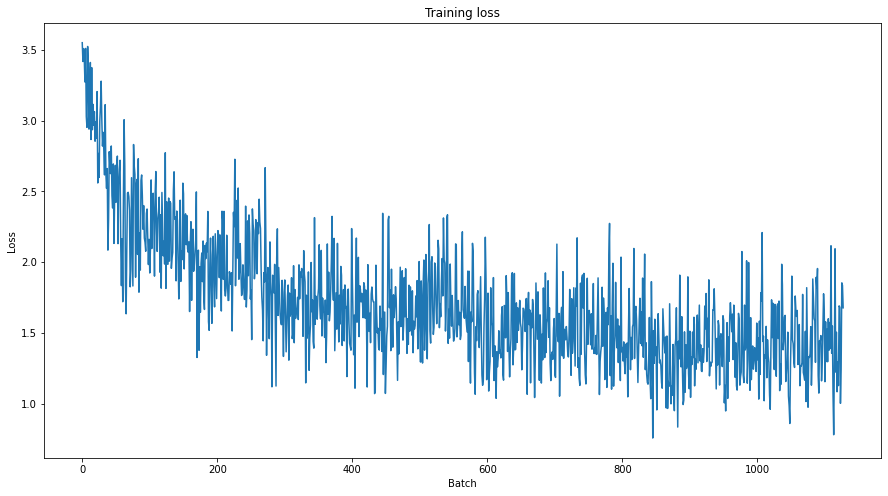

In [23]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

The model performs very bad in terms of accuracy. Pre-processing the data and hyper parameter tuning will help us to achieve better results.